In [15]:
%config InlineBackend.figure_format = "retina"
%cd /home/158/tp1732/lv88/MTI3D

import numpy as np
import os
from obspy import Trace, Stream
from pathlib import Path
from obspy.geodetics import gps2dist_azimuth
import pickle
import emcee
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from mpl_toolkits.basemap import Basemap

mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['font.size'] = 10

/g/data/lv88/MTI3D


## Preparation

### Read synthetic data simulated by SES3D
We read the pre-computed Green's function generated by SES3D for Kim et al. (2016) earth model for the Korean Peninsula region and its random pertubations.

In [16]:
_COMPs = {'r': 'r', 'theta': 't', 'phi': 'p'}
_EMTs = {'M_theta_theta':'Mtt', 'M_phi_phi':'Mpp', 'M_r_r':'Mrr', 
         'M_theta_phi':'Mtp', 'M_theta_r':'Mtr', 'M_phi_r':'Mpr'}

mask = np.array([1,1,0,1,1,1,0,0,1,0,0,0],dtype=bool)
vred = 3.5 # km/s
t0 = 35 # seconds after origin
wlen=115 # length of seismograms in seconds

## reference Greens' tensor, which is known
def load_ses3d_gtensor(dname,vred=None,t0=None,wlen=None,dt=1):
    datapath = Path(dname)
    st = Stream()
    # objstats = []
    for emt in _EMTs:
        for fname in sorted((datapath/'DATA'/emt).glob('*.[xyz]')):
            netw, stat = fname.name.split('_')[0].split('.')
            loc = _EMTs[emt]
            ## parsing file name for network and station codes
            with open(str(fname)) as fp: content = fp.readlines()
            ## parse header info
            comp = _COMPs[content[0].split()[0]]
            npts = int(content[1].split()[1])
            delta = float(content[2].split()[1])
            xr, yr, zr = np.array(content[4].split()[1::2]).astype(float)
            xs, ys, zs = np.array(content[6].split()[1::2]).astype(float)
            dist, az, baz = gps2dist_azimuth(90-xs, ys, 90-xr, yr)
            dist /= 1e3
            ## cread data trace
            tr = Trace(header={'delta':delta}, data=np.loadtxt(content[7:]).astype(float))
            ## begin and end times
            if vred is not None:
                tbeg = dist/vred - t0
                tend = tbeg + wlen
                tr.trim(tr.stats.starttime+tbeg,tr.stats.starttime+tend,nearest_sample=False)
                # if (tr.stats.endtime-tr.stats.starttime < wlen):
                #     raise ValueError('Too long window length required.')
            ## append to stream
            st.append(tr)
    ## resample data and convert data into array
    st.resample(1/dt)
    st.filter('bandpass',freqmin=0.02,freqmax=0.05,zerophase=False,corners=3)
    ## convert to array
    nt = st[0].stats.npts
    ne,nc = len(_EMTs),3
    ns = int(len(st)/(ne*nc))
    gtensor = np.array([tr.data for tr in st]).reshape((ne,ns,nc,nt))
    gtensor = np.moveaxis(gtensor, 0, 2)
    return gtensor

def load_ses3d_gtensor_bulk(dname,vred=None,t0=None,wlen=None,dt=1):
    gf_path = dname/'GF3D.pkl'
    if not gf_path.is_file():
        # gtensors = [load_ses3d_gtensor(str(dname),vred,t0,wlen) for dname in dnames]
        with multiprocessing.Pool(4) as pool: 
            func = partial(load_ses3d_gtensor,vred=vred,t0=t0,wlen=wlen)
            gtensors = pool.map(func, sorted(root_path.glob('MODEL???')))
        gtensors = np.array(gtensors)
        with open(str(gf_path), 'wb') as fp:
            pickle.dump(gtensors, fp)
    else:
        with open(str(gf_path), 'rb') as fp:
            gtensors = pickle.load(fp)
    return gtensors

### Generate synthetic data

In [17]:
ne = 6
m6_true = np.array([.9, .8, .7, -.3, .2, .1])

### Helper functions regarding covariance matrices, their inversion and determinant
We calculate the structural uncertainty covariance matrices using an ensemble of seismograms correspdong to small pertubartion from a regional Earth's model.

In [18]:
def calc_Cov_t(m6, gtensors, gtensor_ref=None):
    nm, _, _, _, _ = gtensors.shape
    ## ensemble of synthetic waveforms
    syn = m6 @ gtensors
    if gtensor_ref is None:
        dev = syn - np.mean(syn, axis=0)
    else:
        dev = syn - m6 @ gtensor_ref
    ## theoretical covariance matrices
    Cov_t = np.mean(np.einsum('msct,mscu->msctu', dev, dev), axis=0) / (nm - 1)
    return Cov_t

Covariance matrices of data noise and structural uncertainty oftain contain small values. Thus, it is necessary to calculate their inversion and determinant with care. Here, we firstly compute the Cholesky decompose the matricies to obtain their lower triangular matrices. This helps avoid potential under-flow or over-flow errors relating to the determinant of a large matrix.

In [19]:
def calc_inv_det(Cov, return_iLow=False):
    ns, nc, _, _ = Cov.shape
    ## Cholesky decomposition of low triangular matrix
    lower = np.linalg.cholesky(Cov)
    ## calculation of inversion of determinant
    iCov = np.zeros_like(Cov)
    log_Cov_det = np.zeros(Cov.shape[:-2])
    if return_iLow: iLow = np.zeros_like(Cov)
    for s in range(ns):
        for c in range(nc):
            lower_inv = scipy.linalg.inv(lower[s, c], True)
            if return_iLow: iLow[s, c] = lower_inv
            iCov[s, c] = lower_inv.T @ lower_inv
            log_Cov_det[s, c] = 2*np.sum(np.log(np.diag(lower[s, c])))
    ##
    if return_iLow:
        return iCov, log_Cov_det, iLow
    else:
        return iCov, log_Cov_det

### Numerical examples

The figure below show the example of the structural uncertainty covariance matrices and corresponding waveform ensemble.

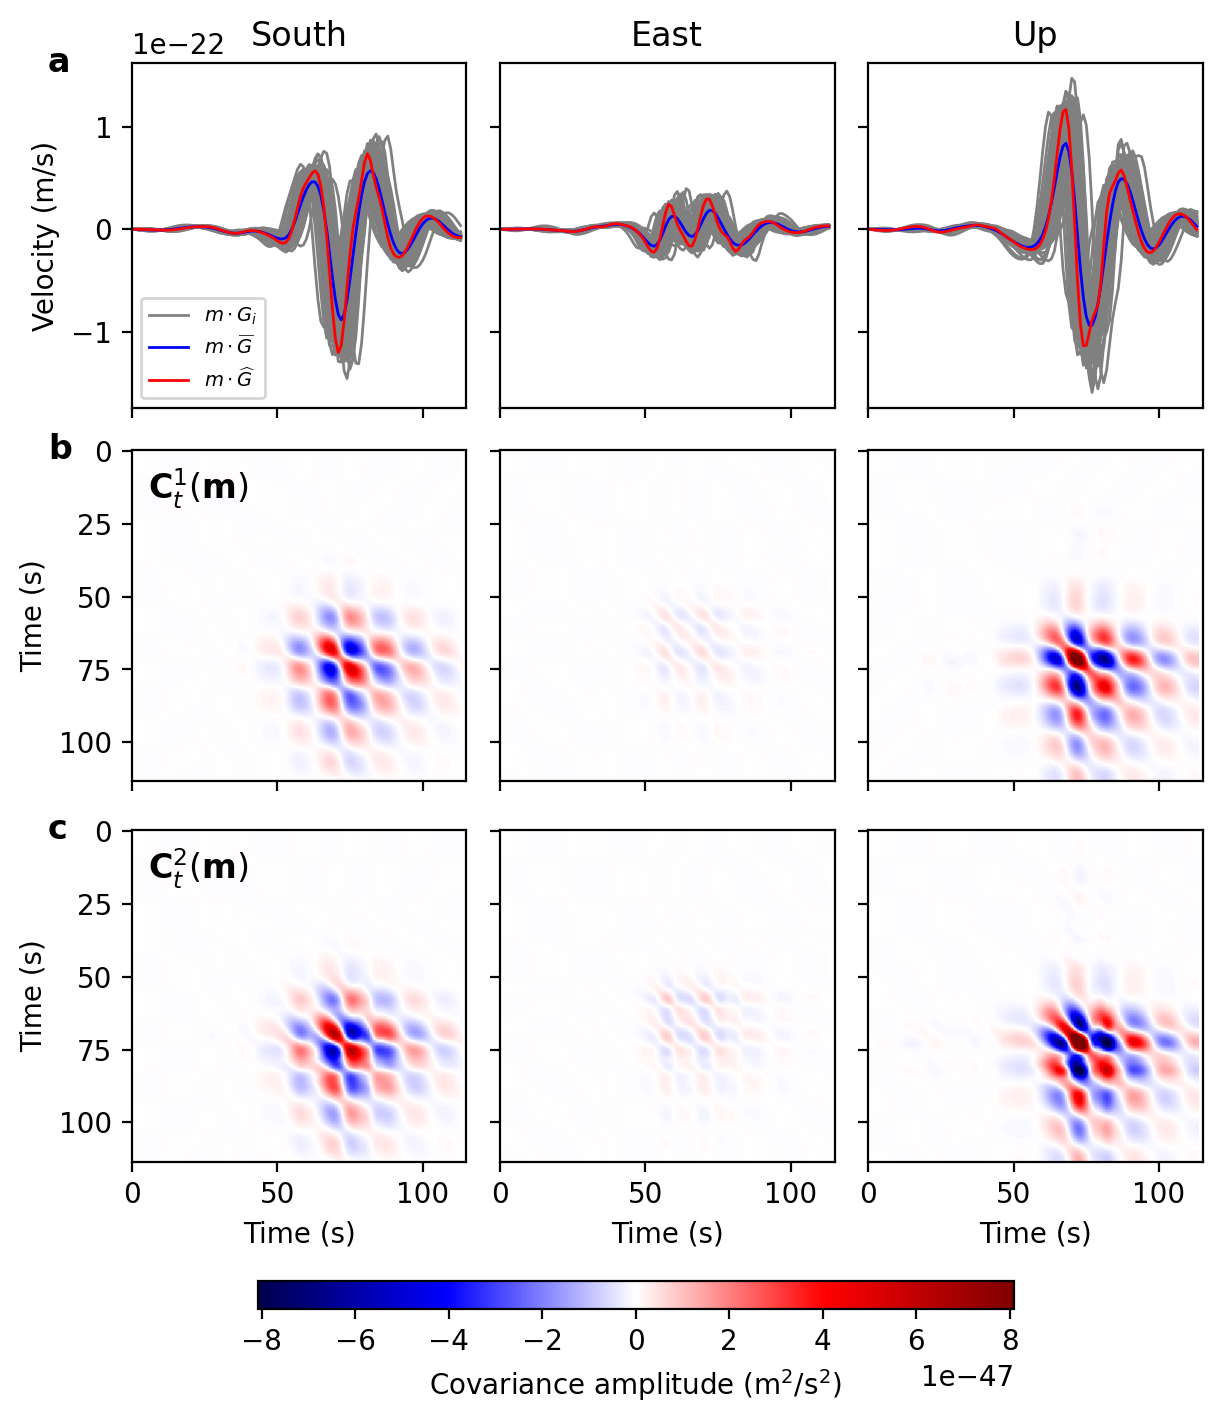

In [20]:
def plot_Cov_t_example(root_path):
    ## Reference models of the known velocity models
    gtensor_ref = load_ses3d_gtensor('ses3d_r07_b', vred=vred,t0=t0,wlen=wlen)
    gtensor_ref = gtensor_ref[mask, :, :, :-1]
    
    ## Green's functions of randomised Earth's structures
    gtensors = load_ses3d_gtensor_bulk(root_path,vred,t0,wlen)
    gtensors = gtensors[:,mask,:,:,:-1]
    nm, ns, nc, ne, nt = gtensors.shape

    ## Generate synthetic seismograms with uncorrelated data noise
    # ref = m6_true @ gtensors
    # noise_std = np.std(ref, axis=-1) * 0.02
    # obs = ref + np.einsum('msct,msc->msct',np.random.normal(0,1,obs.shape),noise_std)

    ## structral uncertainty covariance matrices
    Cov_t = calc_Cov_t(m6_true, gtensors)
    Cov_t_prime = calc_Cov_t(m6_true, gtensors, gtensor_ref)
    fig, ax = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(6.3,7),
                            gridspec_kw={'hspace': 0.1, 'wspace': 0.1, 'left': 0.1, 'right': 0.95, 'top': 0.95, 'bottom': 0.16})
    for c in range(nc):
        vmax = np.max(np.abs(Cov_t[0, 0]))*1.5
        ax[1,c].imshow(Cov_t[0, c],vmin=-vmax,vmax=vmax,cmap='seismic')
        ax[2,c].imshow(Cov_t_prime[0, c],vmin=-vmax,vmax=vmax,cmap='seismic')
    ax[1,0].set(ylabel='Time (s)')
    ax[1,0].annotate(r'$\mathbf{C}_t^1(\mathbf{m})$', xy=(0.05, 0.95), xycoords='axes fraction', va='top', fontsize=12)
    ax[1,0].annotate('b', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    ax[2,0].set(ylabel='Time (s)')
    ax[2,0].annotate(r'$\mathbf{C}_t^2(\mathbf{m})$', xy=(0.05, 0.95), xycoords='axes fraction', va='top', fontsize=12)
    ax[2,0].annotate('c', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    ## ensemble of synthetic seismograms
    titles = ['South','East','Up']
    syn = m6_true @ gtensors
    ref = m6_true @ gtensor_ref
    mean = np.mean(syn, axis=0)
    tvec = np.arange(nt)
    for c in range(nc):
        for m in range(nm): ax[0,c].plot(tvec, syn[m,0,c], lw=1, c='gray', label=('$m\cdot G_i$' if m==0 else None))
        ax[0,c].plot(tvec, mean[0,c], lw=1, c='b', label='$m\cdot \widebar{G}$')
        ax[0,c].plot(tvec, ref[0,c], lw=1, c='r', label='$m\cdot \widehat{G}$')
        ax[0,c].set(title=titles[c])
        ax[2,c].set(xlabel='Time (s)')
    ax[0,0].set(xlim=(0, wlen), ylabel='Velocity (m/s)')
    ax[0,0].legend(loc='lower left', fontsize=7)
    ax[0,0].annotate('a', xy=(-0.25, 1), xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')
    
    ## axis for colorbars
    cax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
    cb = mpl.colorbar.ColorbarBase(cax, cmap='seismic', norm=mpl.colors.Normalize(vmin=-vmax, vmax=vmax), orientation='horizontal')
    cb.set_label('Covariance amplitude (m$^2$/s$^2$)')
    plt.show()
    
if __name__ == '__main__':
    root_path = Path('ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2')
    plot_Cov_t_example(root_path)

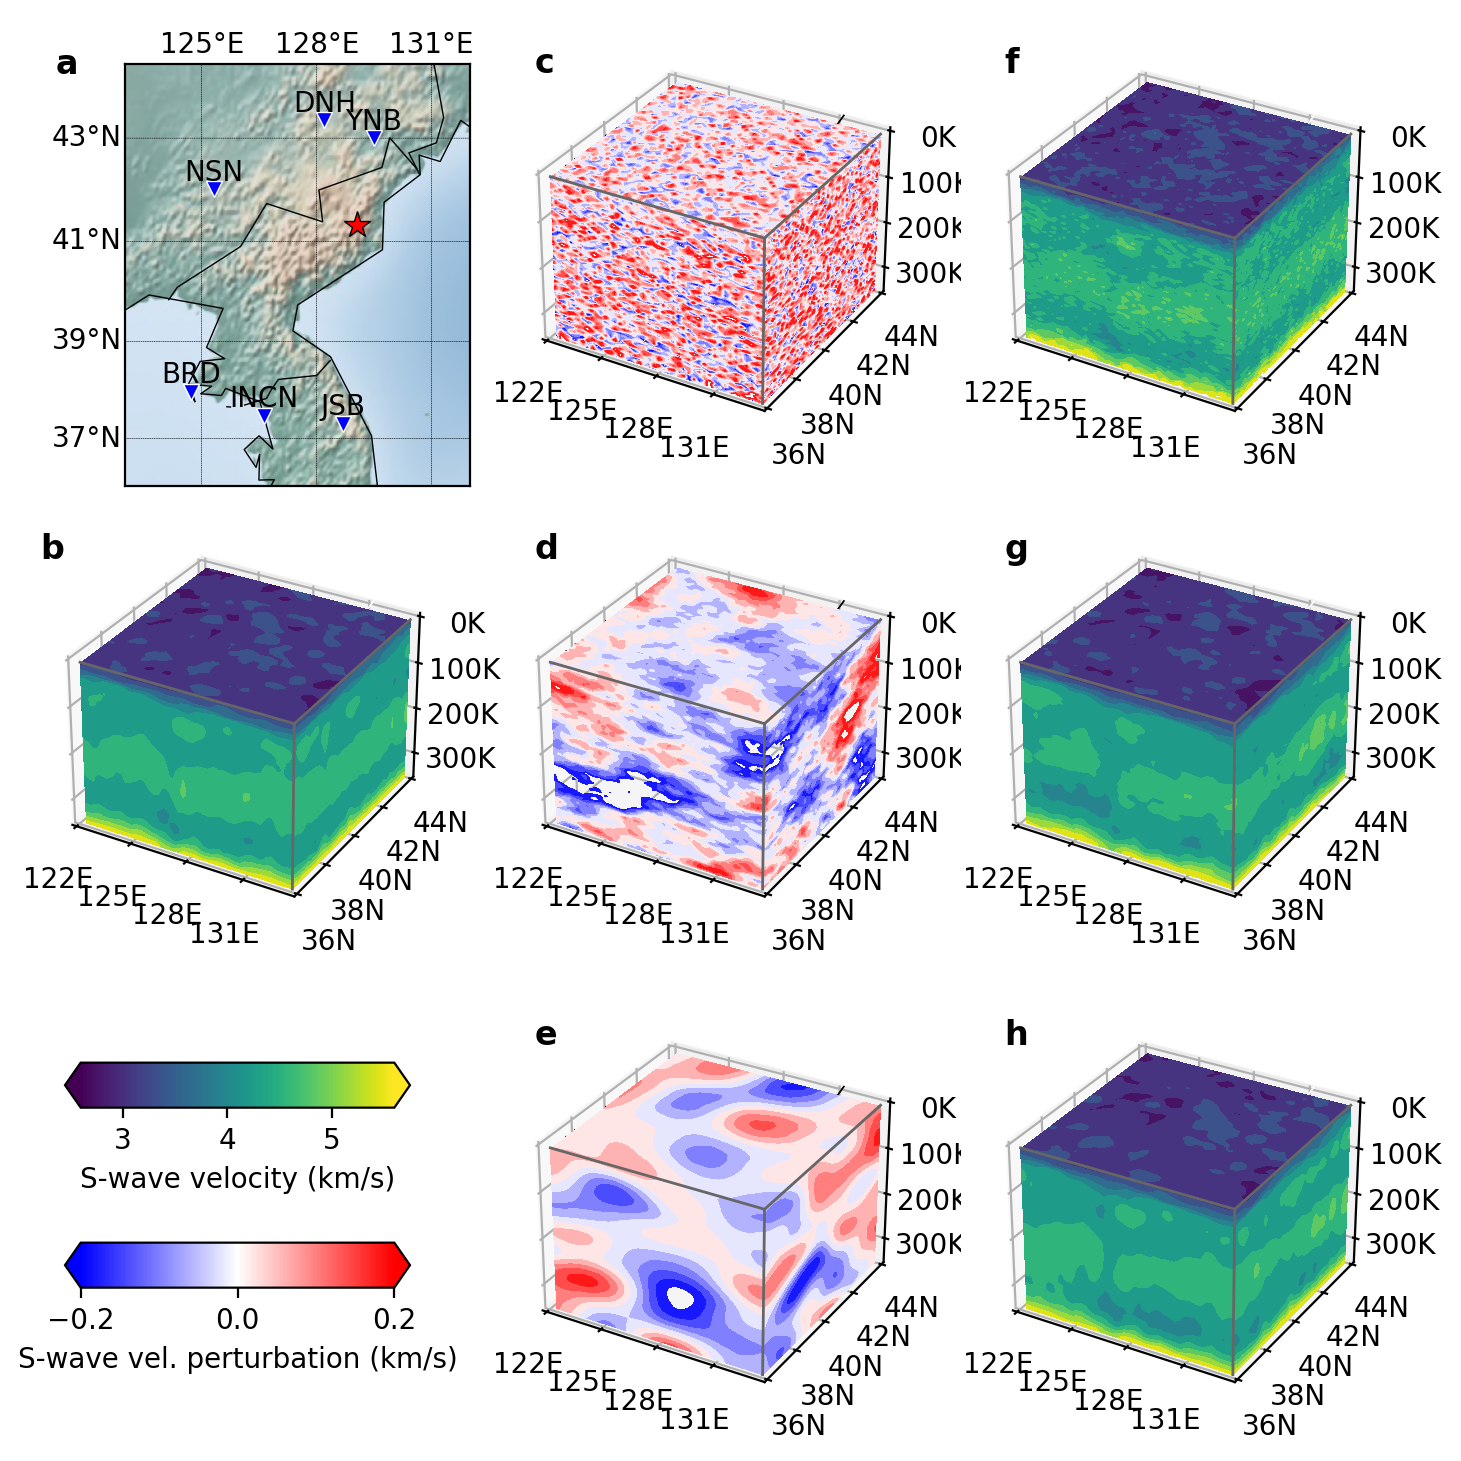

In [21]:
def read_station_info():
    from obspy.geodetics import gps2dist_azimuth
    stat_list = []
    for fname in sorted(Path('ses3d_r07_b').glob('DATA/M_r_r/*.x')):
        with open(fname) as fp:
            content = fp.readlines()
            stla = 90 - float(content[4].split()[1])
            stlo = float(content[4].split()[3])
            evla = 90 - float(content[6].split()[1])
            evlo = float(content[6].split()[3])
            dist,az,_ = gps2dist_azimuth(evla,evlo,stla,stlo)            
            stnm = fname.name.split('_')[0].split('.')[1]
            stat = {'name':stnm, 'stla':stla, 'stlo':stlo, 'dist':dist/1e3, 'azim': az}
            stat_list.append(stat)
    stat_list = np.array(stat_list)[mask]
    return stat_list

def read_3d_model(model_dname='ses3d_r07_b'):
    dname = '%s/MODELS/MODELS_3D' % model_dname
    x = np.loadtxt('%s/block_x' % dname)[2:]
    x = 90-.5*(x[1:]+x[:-1])

    y = np.loadtxt('%s/block_y' % dname)[2:]
    y = .5*(y[1:]+y[:-1])

    z = np.loadtxt('%s/block_z' % dname)[2:]
    z = 6371-.5*(z[1:]+z[:-1])

    nbx = len(x)
    nby = len(y)
    nbz = len(z)
    idx,idy,idz = np.mgrid[0:nbx,0:nby,0:nbz]

    X = x[idx]
    Y = y[idy]
    Z = z[idz]
    model3d = np.loadtxt('%s/dvsv' % dname)[2:].reshape((nbx, nby, nbz))
    
    return X, Y, Z, model3d

def plot_3d_model(ax,X,Y,Z,data,kw,line_kw):
    # Naming convention: 
    #    capital letters: geographic coordinates, X: latitude, Y: longitude, Z: depth
    #    lower case letters: Caterisan coordinates converted from geographic coordinates

    # Region of interest
    Xmin, Xmax = 36, 44.4
    Ymin, Ymax = 123-.6, 132+.6
    # Trim data within the region of interest
    mask = ((X>=Xmin) & (X<=Xmax)) & ((Y>=Ymin) & (Y<=Ymax))
    dims = [np.max(np.sum(mask, axis=_)) for _ in range(3)]
    X = X[mask].reshape(dims)
    Y = Y[mask].reshape(dims)
    Z = Z[mask].reshape(dims)
    data = data[mask].reshape(dims)
    # Define the bedmap coordinate system
    bm = Basemap(projection='merc',resolution=bm_resolution,
                 llcrnrlat=Xmin,urcrnrlat=Xmax,
                 llcrnrlon=Ymin,urcrnrlon=Ymax)
    y, x = bm(Y, X) # convert grid data from geographic to Cartesian coordinates
    z = Z
    # Plot contour surfaces
    ax.contourf(x[:, :, -1], y[:, :, -1], data[:, :, -1], zdir='z', offset=z.min(), **kw)
    ax.contourf(data[0, :, :], y[0, :, :], z[0, :, :], zdir='x', offset=x.max(), **kw)
    ax.contourf(x[:, 0, :], data[:, 0, :], z[:, 0, :], zdir='y', offset=y.min(), **kw)
    # Plot coastlines and countries in the map
    ax.add_collection3d(bm.drawcoastlines(**line_kw))
    ax.add_collection3d(bm.drawcountries(**line_kw))
    # Plot source location
    # xx, yy = bm(129.049, 41.320)
    # ax.plot(xx, yy, 0, 'k*', zdir='z', ms=5)
    # Determine limits of the plot from coord limits
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    zmin, zmax = z.min(), z.max()
    # Set limits of the plot from coord limits
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmax, zmin])
    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    # Set labels and zticks
    Xticks = np.arange(36,44.1,2, dtype=int)
    Yticks = np.arange(122,132.1,3, dtype=int)
    _, xticks = bm(ymin*np.ones_like(Xticks), Xticks)
    yticks, _ = bm(Yticks, xmax*np.ones_like(Yticks))
    zticks = np.linspace(0,300,4, dtype=int)
    ax.set(zticks=zticks, zticklabels=[f'{_}K' for _ in zticks])
    ax.set(xticks=yticks, xticklabels=[f'{_}E' for _ in Yticks])
    ax.set(yticks=xticks, yticklabels=[f'{_}N' for _ in Xticks])
    #Set zoom and angle view
    ax.set_box_aspect(None, zoom=0.9)

def plot_model_perturbation(root_dnames):
    ### Create a figure with 3D ax
    X, Y, Z, ref_model3d = read_3d_model()

    fig = plt.figure(figsize=(7.5, 7.5))
    gs = fig.add_gridspec(3, 3, left=0., right=0.92, wspace=0.07, bottom=0.05, top=1.0, hspace=0.07)
    label_kw = dict(xycoords='axes fraction', va='center', fontsize=12, fontweight='bold')

    for d in range(len(root_dnames)):
        root_path = Path(root_dnames[d])
        ax = fig.add_subplot(gs[d, 1], projection='3d')
        # a random perturbed model
        _, _, _, ran_model3d = read_3d_model(root_path/'MODEL001')
        # plot redidual model
        plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
        ax.annotate('%c'%(99+d), xy=(0.1,0.9), **label_kw)
        # plot perturbed model
        ax = fig.add_subplot(gs[d, 2], projection='3d')
        plot_3d_model(ax, X, Y, Z, ran_model3d, kw0, line_kw0)
        ax.annotate('%c'%(99+len(root_dnames)+d), xy=(0.1,0.9), **label_kw)

    # orignal model
    ax = fig.add_subplot(gs[1, 0], projection='3d')
    ax.annotate('b', xy=(0.1,0.9), ha='right', **label_kw)
    plot_3d_model(ax, X, Y, Z, ref_model3d, kw0, line_kw0)
            
    ####### LOCATION MAP
    ax = fig.add_axes([0.07, 0.65, 0.23, 0.35])
    ax.annotate('a', xy=(-0.2, 1), **label_kw)
    bm = Basemap(projection='merc',resolution=bm_resolution,ax=ax,
                 llcrnrlat=36,urcrnrlat=44.4,
                 llcrnrlon=123,urcrnrlon=132)
    bm.shadedrelief()
    bm.drawcoastlines(linewidth=0.5)
    bm.drawcountries(linewidth=0.5)
    bm.drawparallels(range(33,46,2),labels=(1,0,0,0),linewidth=.2,dashes=(3,1))
    bm.drawmeridians(range(122,133,3),labels=(0,0,1,0),linewidth=.2,dashes=(3,1))
    ## station
    stat_list = read_station_info()
    stla = [s['stla'] for s in stat_list]
    stlo = [s['stlo'] for s in stat_list]
    xx,yy = bm(stlo,stla)
    ax.plot(xx,yy,'v', c='b', mec='w', mew=.5)
    for i in range(len(stat_list)):
        ax.text(xx[i], yy[i]+25e3, stat_list[i]['name'], ha='center')
    xx, yy = bm(129.049, 41.320)
    ax.plot(xx,yy,'*', c='r', mec='k', mew=.5, ms=10)

    ####### COLORMAP LEGEND
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(kw0['vmin'], kw0['vmax']), cmap=kw0['cmap']), 
                 orientation='horizontal', label='S-wave velocity (km/s)', extend='both',
                 cax=fig.add_axes([0.03, 0.27, 0.23, 0.03]))
    
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(kw1['vmin'], kw1['vmax']), cmap=kw1['cmap']), 
                 orientation='horizontal', label='S-wave vel. perturbation (km/s)', extend='both',
                 cax=fig.add_axes([0.03, 0.15, 0.23, 0.03]))

    ## Save figure
    # plt.savefig('ModelPerturbation.pdf')
    plt.show()

if __name__ == '__main__':
    # universal parameters
    kw0 = {'vmin': 2.6,'vmax': 5.6,'levels': np.linspace(2.6, 5.6, 11), 'cmap':'viridis'}
    line_kw0 = {'linewidth': .5, 'color': 'w'}
    kw1 = {'vmin': -.2,'vmax': .2,'levels': np.linspace(-.2, .2, 11),'cmap': 'bwr'}
    line_kw1 = {'linewidth': .5, 'color': 'k'}
    # bm_resolution='i'
    bm_resolution='c'
    # set of models to show
    root_dnames = ['ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/3',
                   'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/2',
                   'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2']
    plot_model_perturbation(root_dnames)

## Linear MT inversion

In [22]:
## Linear solution
def LinSolve(gtensor_ref, iCov, obs): 
    TMP = gtensor_ref @ iCov
    LHS = np.mean(TMP @ np.transpose(gtensor_ref, axes=(0, 1, 3, 2)), axis=(0, 1))
    RHS = np.mean(np.einsum('...ij,...j->...i', TMP, obs), axis=(0, 1))
    lsol = np.linalg.inv(LHS) @ RHS
    return lsol

## Iterative solution from a random prior
def IterSolve(gtensor_ref, obs, noise_std, m6, gtensors, use_Ct_prime=False, n_iters=5):
    nm, ns, nc, ne, nt = gtensors.shape
    m6_chain = []
    ## Iterative solution
    m6_chain.append(m6)
    for ii in range(n_iters):
        # structural uncertainty covariance matrix
        Cov_t = calc_Cov_t(m6, gtensors, gtensor_ref if use_Ct_prime else None)
        # combined covariance matrix with uncorrelated data noise
        Cov = np.einsum('sc...,sc->sc...', Cov_t, noise_std**-2) + np.eye(nt)
        # covariance matrices' inversion and determinant
        iCov, log_Cov_det = calc_inv_det(Cov)
        iCov = np.einsum('sc...,sc->sc...', iCov, noise_std**-2)
        # linear solver
        m6 = LinSolve(gtensor_ref, iCov, obs)
        m6_chain.append(m6)
    return np.array(m6_chain)

# Gridsearch for MT with timeshifts

## Method demonstration

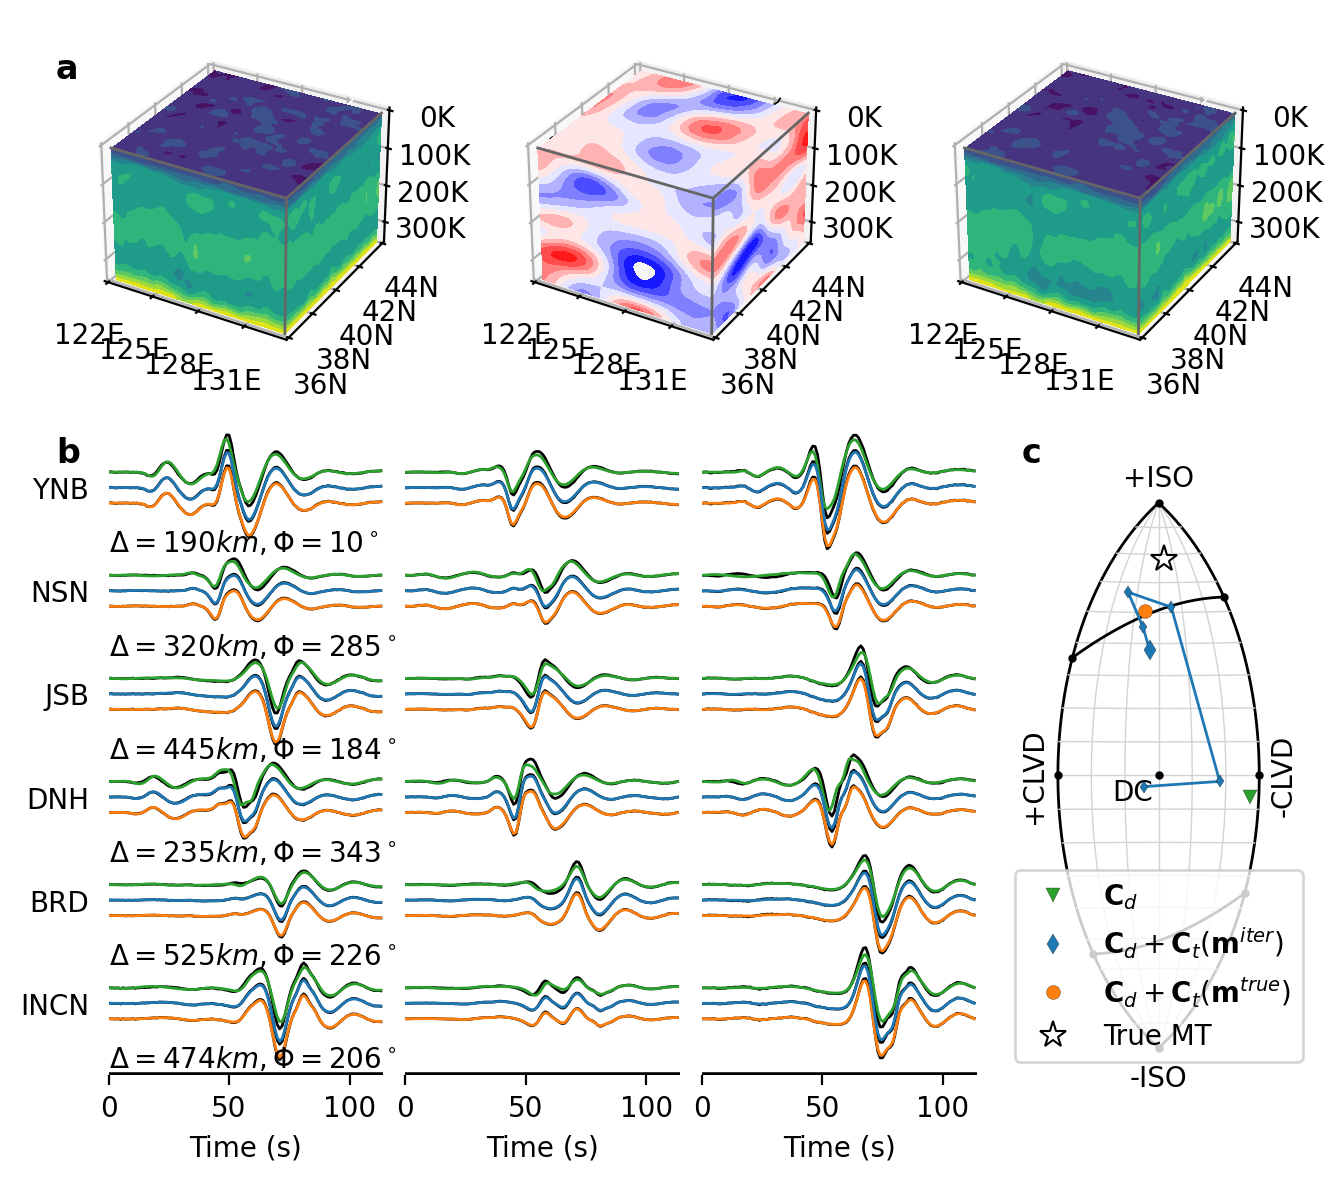

In [23]:
from UTIL import plot_lune_frame, mt2lune

def plot_solutions_on_lune(ax, sol_dict, show_legend=True, lune_kw=None):
    ## PLOT SOLUTIONS
    ax.set(frame_on=False, xticks=[], yticks=[])
    bm = plot_lune_frame(ax, **lune_kw)

    for key, val in sol_dict.items():
        m6_sol = val['mt_sol']
        lon, lat = mt2lune(m6_sol[...,0], m6_sol[...,1], m6_sol[...,2], 
                           m6_sol[...,3], m6_sol[...,4], m6_sol[...,5])
        x,y = bm(lon,lat)
        ax.plot(x, y, **val['sol_kw'])

def visualize_solutions(root_path, model_idx=0):
    ## Reference models of the known velocity models
    gtensor_ref = load_ses3d_gtensor('ses3d_r07_b', vred=vred,t0=t0,wlen=wlen)
    gtensor_ref = gtensor_ref[mask, :, :, :-1]
    
    ## Green's functions of randomised Earth's structures
    gtensors = load_ses3d_gtensor_bulk(root_path,vred,t0,wlen)
    gtensors = gtensors[:,mask,:,:,:-1]
    nm, ns, nc, ne, nt = gtensors.shape

    ## Generate synthetic seismograms with uncorrelated data noise
    obs = m6_true @ gtensors
    noise_std = np.std(obs, axis=-1) * 0.02
    obs += np.einsum('msct,msc->msct',np.random.normal(0,1,obs.shape),noise_std)

    ## MT solution without structure uncertainty but allowing time shifts
    # m6_sol_w_timeshift = GridSolve(gtensor_ref, obs[model_idx], 11)

    ## MT solution with structure uncertainty
    m6 = np.random.uniform(-1, 1, 6)
    m6_chain = IterSolve(gtensor_ref, obs[model_idx], noise_std[model_idx], m6, gtensors)
    m6_sol_wu_strucerror = m6_chain

    ## combined covariance matrix with uncorrelated data noise
    Cov_t = calc_Cov_t(m6_true, gtensors)
    Cov = np.einsum('sc...,sc->sc...', Cov_t, noise_std[model_idx]**-2) + np.eye(nt)
    iCov, _ = calc_inv_det(Cov)
    iCov = np.einsum('sc...,sc->sc...', iCov, noise_std[model_idx]**-2)
    m6_sol_w_strucerror = LinSolve(gtensor_ref, iCov, obs[model_idx])

    ## MT solution without structure uncertainty
    iCov1 = np.zeros((ns, nc, nt, nt))
    for s in range(ns):
        for c in range(nc):
            iCov1[s, c] = np.eye(nt) * noise_std[model_idx, s, c]**-2
    m6_sol_wo_strucerror = LinSolve(gtensor_ref, iCov1, obs[model_idx])

    ## 3D Earth model for reference
    X, Y, Z, ref_model3d = read_3d_model()
    _, _, _, ran_model3d = read_3d_model(root_path/'MODEL001')

    ## FIGURE INITIATION
    pred_wo_strucerror = m6_sol_wo_strucerror @ gtensors[0] 
    pred_w_strucerror = m6_sol_w_strucerror @ gtensors[0] 
    pred_wu_strucerror = m6_sol_wu_strucerror[-1] @ gtensors[0]
    # pred_w_timeshift = m6_sol_w_timeshift @ gtensors[0]
    gridspec_kw={'top':0.65, 'bottom':0.10, 'left':0.10, 'right':0.72, 'wspace':0.08}
    fig, axarr = plt.subplots(1, 3, figsize=(7, 6), gridspec_kw=gridspec_kw, sharex=True, sharey=True)
    scale = .7 / np.max(np.abs(obs))
    stat_list = read_station_info()
    for c in range(nc):
        axarr[c].set(frame_on=False)
        for s in range(ns):
            ## synthetic observation
            data = obs[model_idx, s, c]*scale
            tvec = np.arange(nt)
            axarr[c].plot(tvec, data+s-.15, lw=1, c='k')
            axarr[c].plot(tvec, data+s+.15, lw=1, c='k')
            axarr[c].plot(tvec, data+s, lw=1, c='k')
            ## predicted waveforms with structural error
            data = pred_w_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s-.15, lw=1, c='C1')
            ## predicted waveform with time shift
            # data = -pred_w_timeshift[s, c]*scale
            # axarr[c].plot(tvec, data+s+.15, lw=1, c='C3')
            ## predicted waveforms without structural error
            data = pred_wo_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s+.15, lw=1, c='C2')
            ## predicted waveforms with unknown structural error
            data = pred_wu_strucerror[s, c]*scale
            axarr[c].plot(tvec, data+s, lw=1, c='C0')

            ## station information 
            if c==0:
                txt = '$\Delta = %dkm, \Phi = %d^\circ$' % (stat_list[s]['dist'], stat_list[s]['azim'])
                axarr[c].annotate(txt, xy=(0, s-.4), va='top')
        ## axes annotation
        axarr[c].plot([0, nt], [-.7,-.7], lw=2, c='k')
        axarr[c].set(xlabel='Time (s)')
        axarr[c].tick_params(left=False)
    axarr[0].set(xlim=(0, nt), ylim=(-.7, 5.7), yticks=range(6), yticklabels=[stat['name'] for stat in stat_list])
        
    ## Plot solutions
    ax = fig.add_axes([0.75, 0.1, 0.2, 0.5])
    ax.set(frame_on=False, xticks=[], yticks=[])
    bm = plot_lune_frame(ax)
    
    #solution without strucerror
    lon, lat = mt2lune(m6_sol_wo_strucerror[0], m6_sol_wo_strucerror[1], m6_sol_wo_strucerror[2], 
                       m6_sol_wo_strucerror[3], m6_sol_wo_strucerror[4], m6_sol_wo_strucerror[5])
    x,y = bm(lon,lat)
    ax.plot(x, y, ms=5, mew=.1, c='C2', mec='k', marker= 'v', lw=0, label=r'$\mathbf{C}_d$')
    # solution with time shift
    # lon, lat = mt2lune(m6_sol_w_timeshift[0], m6_sol_w_timeshift[1], m6_sol_w_timeshift[2],
    #                     m6_sol_w_timeshift[3], m6_sol_w_timeshift[4], m6_sol_w_timeshift[5])
    # x,y = bm(lon,lat)
    # ax.plot(x, y, ms=5, mew=.1, c='C3', mec='k', marker= 'h', lw=0, label=r'$\mathbf{C}_d$')
    #solution with unknown strucerror
    lon, lat = mt2lune(m6_sol_wu_strucerror[:,0], m6_sol_wu_strucerror[:,1], m6_sol_wu_strucerror[:,2], 
                       m6_sol_wu_strucerror[:,3], m6_sol_wu_strucerror[:,4], m6_sol_wu_strucerror[:,5])
    x,y = bm(lon,lat)
    ax.plot(x, y, '-d', ms=3, lw=1, c='C0', mec='k', mew=.1)#, label='$C_d + C_t(m^p)$')
    ax.plot(x[-1], y[-1], ms=5, c='C0', mew=.1, mec='k', marker= 'd', lw=0, label=r'$\mathbf{C}_d + \mathbf{C}_t(\mathbf{m}^{iter})$')
    #solution with well-known strucerror
    lon, lat = mt2lune(m6_sol_w_strucerror[0], m6_sol_w_strucerror[1], m6_sol_w_strucerror[2], 
                       m6_sol_w_strucerror[3], m6_sol_w_strucerror[4], m6_sol_w_strucerror[5])
    x,y = bm(lon,lat)
    ax.plot(x, y, ms=5, mew=.1, c='C1', mec='k', lw=0, marker= 'o', label=r'$\mathbf{C}_d + \mathbf{C}_t(\mathbf{m}^{true})$')
    
    ## TRUE MT SOLUTION
    lon0, lat0 = mt2lune(m6_true[0], m6_true[1], m6_true[2], m6_true[3], m6_true[4], m6_true[5])
    x, y = bm(lon0, lat0)
    ax.plot(x, y, '*', c='none', mec='k', mew=.75, ms=10, label='True MT')
    handles, labels = ax.get_legend_handles_labels()
    unique_handles, unique_labels = [], []
    for h, l in zip(handles,labels):
        if l not in unique_labels:
            unique_handles.append(h)
            unique_labels.append(l)
    ax.legend(unique_handles, unique_labels, loc='lower center')
    ## VELOCITY MODEL FOR REFERENCE
    gridspec_kw={'top':0.98, 'bottom':0.68, 'left':0.05, 'right':0.95, 'wspace':0.05}
    gs = fig.add_gridspec(1, 3, **gridspec_kw)
    ax = fig.add_subplot(gs[0], projection='3d')
    plot_3d_model(ax, X, Y, Z, ref_model3d, kw0, line_kw0)
    ax = fig.add_subplot(gs[1], projection='3d')
    plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
    ax = fig.add_subplot(gs[2], projection='3d')
    plot_3d_model(ax, X, Y, Z, ran_model3d, kw0, line_kw0)
    
    ax.annotate('a', xy=(0.04, 0.92), xycoords='figure fraction', fontsize=12, fontweight='bold')
    ax.annotate('b', xy=(0.04, 0.6), xycoords='figure fraction', fontsize=12, fontweight='bold')
    ax.annotate('c', xy=(0.73, 0.6), xycoords='figure fraction', fontsize=12, fontweight='bold')
    
    ## SAVE FIGURE
    plt.show()
    
if __name__ == '__main__':
    # universal parameters
    kw0 = {'vmin': 2.6,'vmax': 5.6,'levels': np.linspace(2.6, 5.6, 11), 'cmap':'viridis'}
    line_kw0 = {'linewidth': .5, 'color': 'w'}
    kw1 = {'vmin': -.2,'vmax': .2,'levels': np.linspace(-.2, .2, 11),'cmap': 'bwr'}
    line_kw1 = {'linewidth': .5, 'color': 'k'}
    # bm_resolution='i'
    bm_resolution='l'

    root_dname = 'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2'
    root_path = Path(root_dname)
    visualize_solutions(root_path, 0)

## Main result: comparison of different schemes

Small data noise yield nice data results. However, larger data noise is pretty unstable.

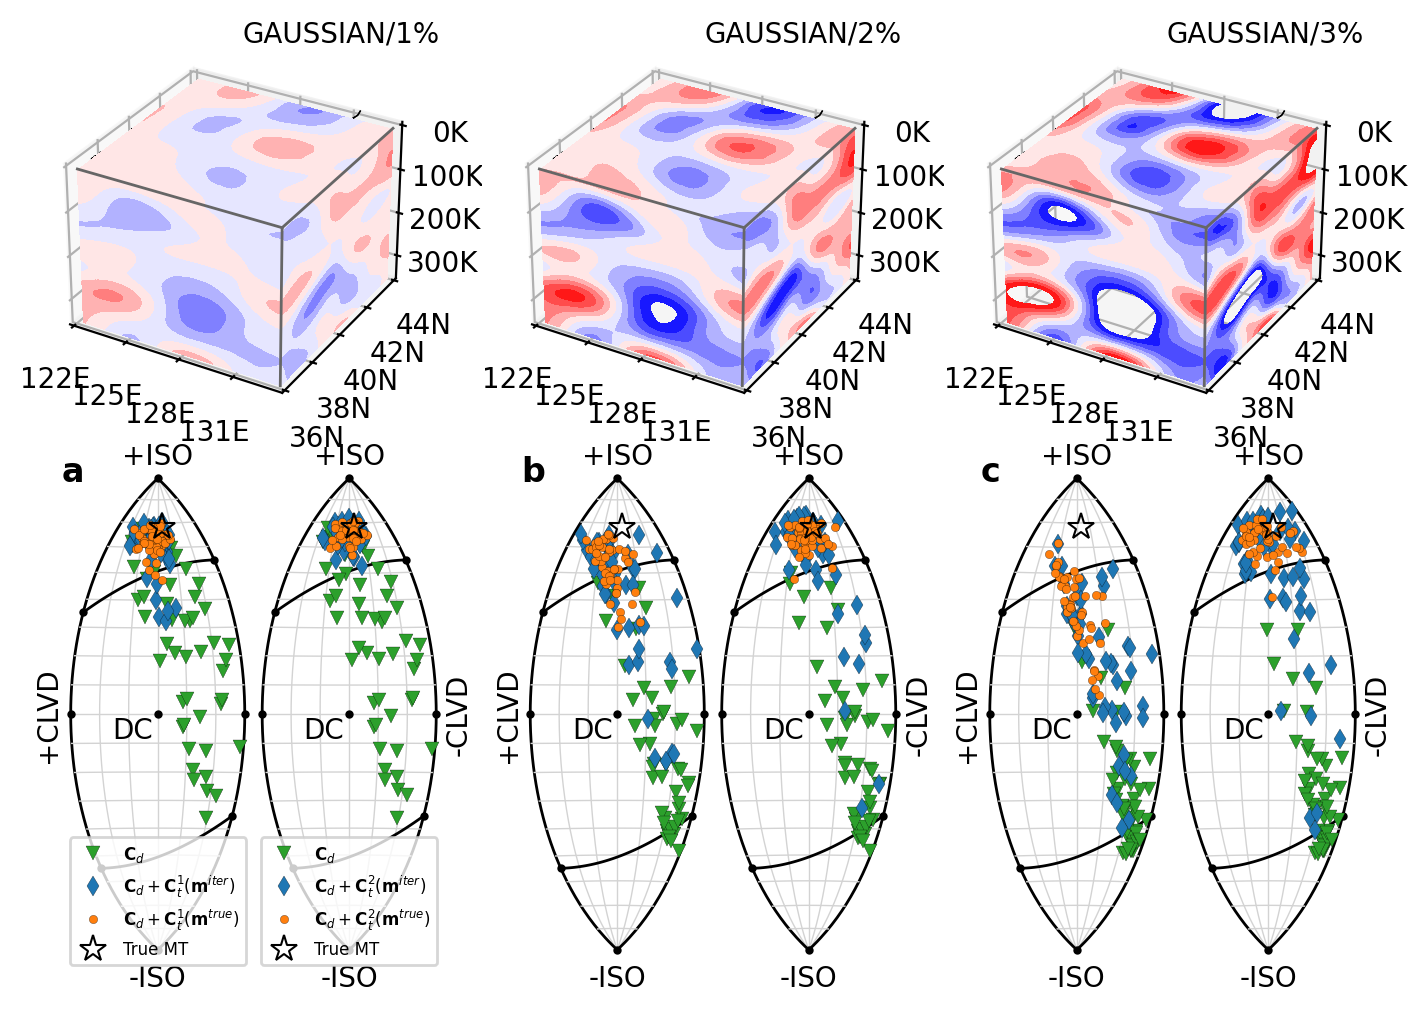

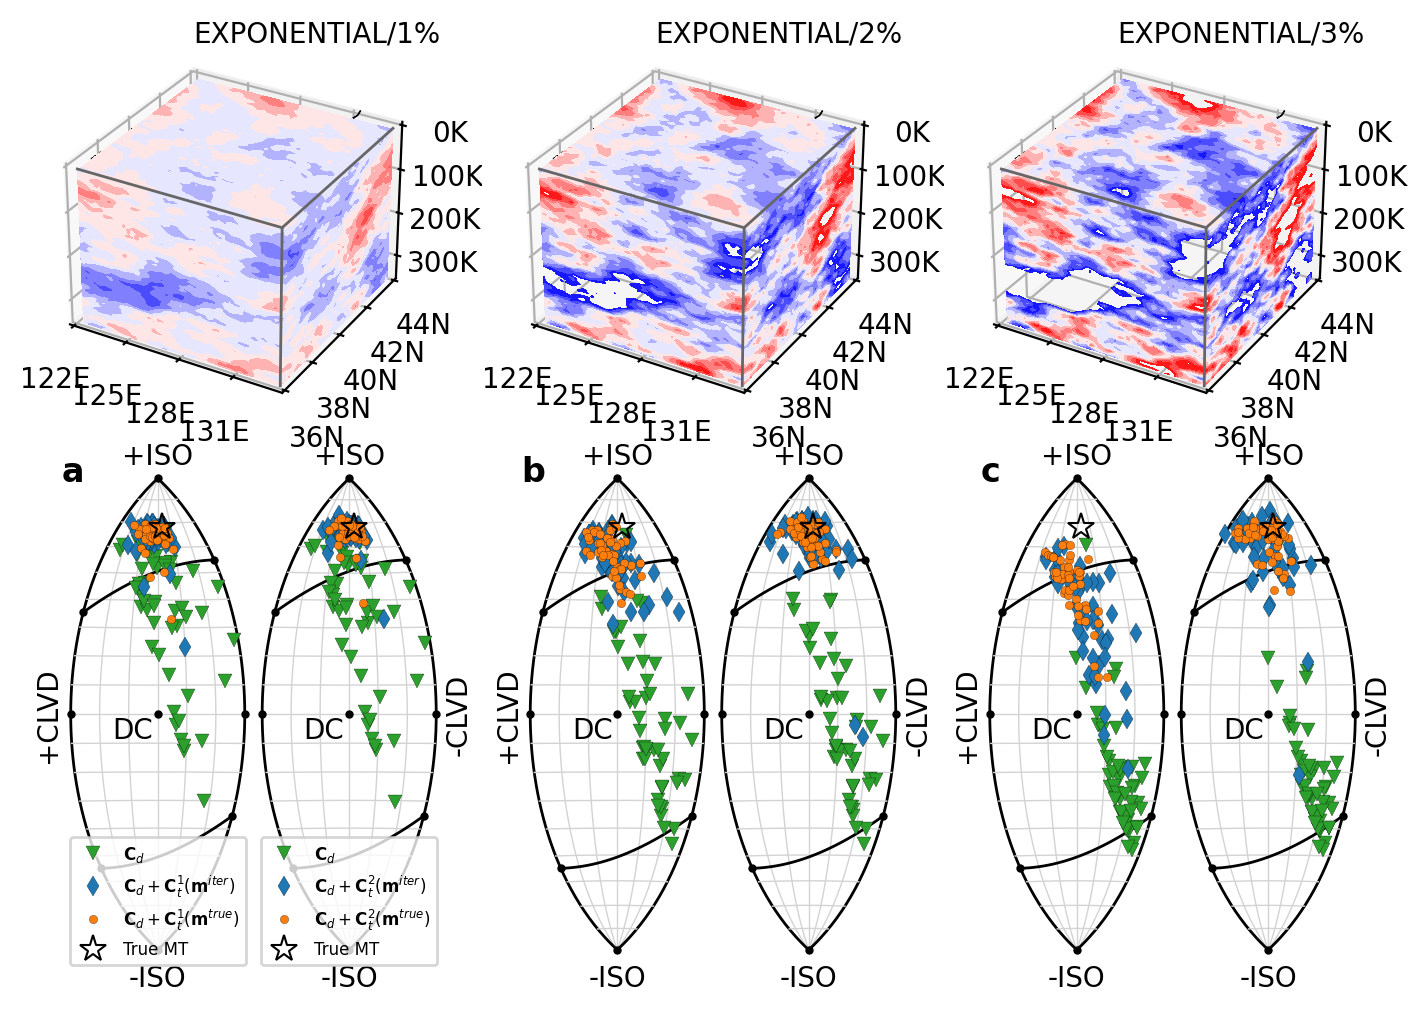

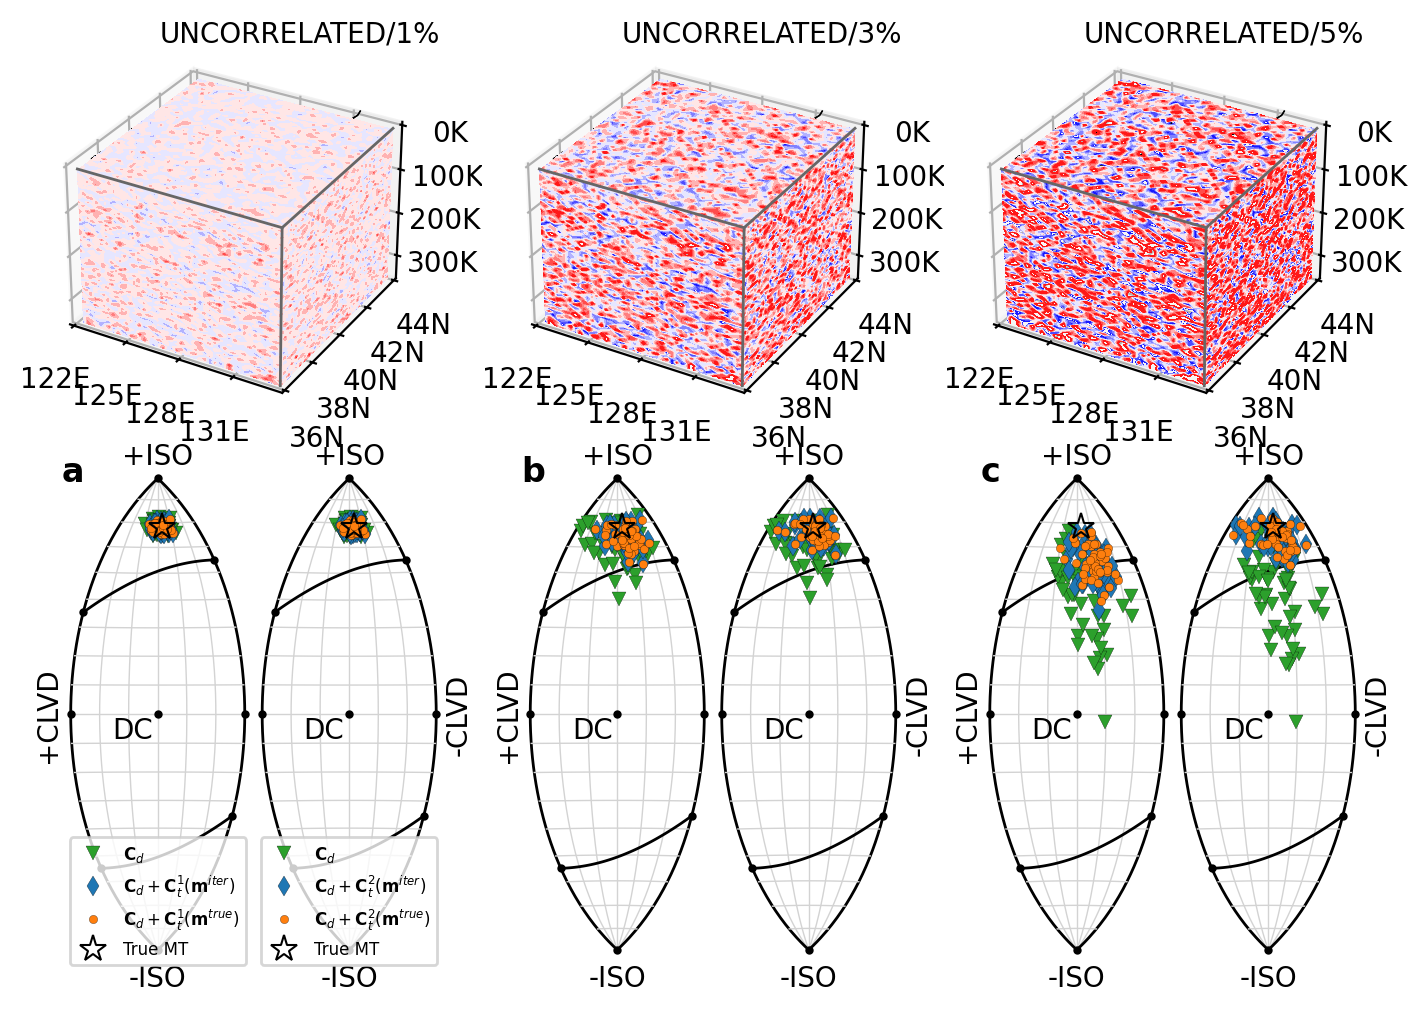

In [24]:
import json
from hashlib import md5

def compare_leastsquare_solutions(root_path, m6_true, noise_scale=0.01, struc_error_factor=1, use_Ct_prime=False):
    ## Reference models of the known velocity models
    gtensor_ref = load_ses3d_gtensor('ses3d_r07_b', vred=vred, t0=t0, wlen=wlen)
    gtensor_ref = gtensor_ref[mask, :, :, :-1]
    
    ## Green's functions of randomised Earth's structures
    gtensors = load_ses3d_gtensor_bulk(root_path, vred, t0, wlen)
    gtensors = gtensors[:,mask,:,:,:-1]
    nm, ns, nc, ne, nt = gtensors.shape

    ## Generate synthetic seismograms with uncorrelated data noise
    obs = m6_true @ gtensors
    noise_std = np.std(obs, axis=-1) * noise_scale
    obs += np.einsum('msct,msc->msct', np.random.normal(0, 1, obs.shape), noise_std)

    ## Solutions for different Earth's models
    m6_sol_w_strucerror = []
    # norm_res_w_strucerror = []
    m6_sol_wu_strucerror = []
    # norm_res_wu_strucerror = []
    m6_sol_wo_strucerror = []
    # norm_res_wo_strucerror = []
    m6_sol_w_timeshift = []

    ## Iterating through simulated Earth's models
    for model_idx in range(nm):
        ## MT solution with structure uncertainty
        m6 = np.random.uniform(-1, 1, 6)
        m6_chain = IterSolve(gtensor_ref, obs[model_idx], noise_std[model_idx], m6, gtensors, use_Ct_prime, n_iters=5)
        m6_sol_wu_strucerror.append(m6_chain[-1, :])

        ## combined covariance matrix with uncorrelated data noise
        Cov_t = calc_Cov_t(m6_true, gtensors, gtensor_ref if use_Ct_prime else None) / struc_error_factor
        # Cov_t = calc_Cov_t(m6_true, gtensors) / struc_error_factor
        Cov = np.einsum('sc...,sc->sc...', Cov_t, noise_std[model_idx]**-2) + np.eye(nt)
        iCov, _, iLow = calc_inv_det(Cov, True)
        iCov = np.einsum('sc...,sc->sc...', iCov, noise_std[model_idx]**-2)
        m6_sol_w_strucerror.append(LinSolve(gtensor_ref, iCov, obs[model_idx]))

        ## MT solution without structure uncertainty
        iCov1 = np.zeros((ns, nc, nt, nt))
        iLow1 = np.zeros((ns, nc, nt, nt))
        for s in range(ns):
            for c in range(nc):
                iLow1[s, c] = np.eye(nt) * noise_std[model_idx, s, c]**-1
                iCov1[s, c] = np.eye(nt) * noise_std[model_idx, s, c]**-2 
        m6_sol_wo_strucerror.append(LinSolve(gtensor_ref, iCov1, obs[model_idx]))

        ## MT solution obtained with time shift
        # m6_sol_w_timeshift.append(GridSolve(gtensor_ref, obs[model_idx]))

    ## Solution list to ndarray
    m6_sol_w_strucerror = np.array(m6_sol_w_strucerror)
    m6_sol_wu_strucerror = np.array(m6_sol_wu_strucerror)
    m6_sol_wo_strucerror = np.array(m6_sol_wo_strucerror)
    # m6_sol_w_timeshift = np.array(m6_sol_w_timeshift)
    return {'wo_strucerror':{'mt_sol':m6_sol_wo_strucerror}, 
            'wu_strucerror':{'mt_sol':m6_sol_wu_strucerror}, 
            'w_strucerror':{'mt_sol':m6_sol_w_strucerror},
            # 'w_timeshift':{'mt_sol':m6_sol_w_timeshift},
            }
if __name__ == '__main__':
    # universal parameters
    kw0 = {'vmin': 2.6,'vmax': 5.6,'levels': np.linspace(2.6, 5.6, 11), 'cmap':'viridis'}
    line_kw0 = {'linewidth': .5, 'color': 'yellow'}
    kw1 = {'vmin': -.2,'vmax': .2,'levels': np.linspace(-.2, .2, 11),'cmap': 'bwr'}
    line_kw1 = {'linewidth': .5, 'color': 'k'}
    # bm_resolution='i'
    bm_resolution='l'

    ### Create a figure with 3D ax
    X, Y, Z, ref_model3d = read_3d_model()

    for root_dnames in [['ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/1',
                   'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2',
                   'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/3'],
                    ['ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/1',
                   'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/2',
                   'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/3'],
                    ['ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/1',
                   'ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/3',
                   'ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/5']]:
        fig = plt.figure(figsize=(7, 5))
        gs_mods = fig.add_gridspec(1, 3, top=1.0, bottom=0.57, left=0.02, right=0.98, wspace=0.1)
        gs_sols = fig.add_gridspec(1, 3, top=0.6, bottom=0.0, left=0.05, right=0.98, wspace=0.2) 

        for c in range(3):
            root_path = Path(root_dnames[c])
            
            ax = fig.add_subplot(gs_mods[c], projection='3d')
            _, _, _, ran_model3d = read_3d_model(root_path/'MODEL001')
            plot_3d_model(ax, X, Y, Z, ran_model3d-ref_model3d, kw1, line_kw1)
            tokens = root_dnames[c].split('/')
            title = '%s/%s' % (tokens[-2][:-3], tokens[-1]) + '%'
            ax.annotate(title, xy=(1, 1), xycoords='axes fraction', va='top', ha='right')

            gs = gs_sols[c].subgridspec(1, 2, wspace=0.)
            for use_Ct_prime in [False, True]:
                dname = Path('tmp')
                if not dname.exists(): dname.mkdir()
                fname = md5(json.dumps([str(root_path), list(m6_true), use_Ct_prime]).encode('utf-8')).hexdigest()
                if Path(dname/fname).exists():
                    with open(dname/fname, 'rb') as f: sol_dict = pickle.load(f)
                else:
                    sol_dict = compare_leastsquare_solutions(root_path, m6_true, noise_scale=0.02, 
                                                        struc_error_factor=1, use_Ct_prime=use_Ct_prime)
                    with open(dname/fname, 'wb') as f: pickle.dump(sol_dict, f)

                ax = fig.add_subplot(gs[int(use_Ct_prime)])
                sol_dict['wo_strucerror']['sol_kw'] = dict(marker='v', c='C2', mec='k', mew=.1, ms=5, lw=0,
                                                        label=r'$\mathbf{C}_d$')
                # sol_dict['w_timeshift']['sol_kw'] = dict(marker='h', c='C3', mec='k', mew=.1, ms=3, lw=0, label='Timeshift')
                sol_dict['wu_strucerror']['sol_kw'] = dict(marker='d', c='C0', mec='k', mew=.1, ms=5, lw=0,
                                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{iter})$'%(use_Ct_prime+1))
                sol_dict['w_strucerror']['sol_kw']  = dict(marker='o', c='C1', mec='k', mew=.1, ms=3, lw=0,
                                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{true})$'%(use_Ct_prime+1))
                sol_dict['mt_true'] = dict(mt_sol=m6_true, sol_kw=dict(marker='*', c='none', mec='k', mew=.75, 
                                                                    ms=10, lw=0, label='True MT'))
                lune_kw = {}
                if use_Ct_prime: lune_kw['clvd_left'] = False
                if not use_Ct_prime: lune_kw['clvd_right'] = False
                plot_solutions_on_lune(ax, sol_dict, lune_kw=lune_kw)
                if c==0: ax.legend(loc='lower center', fontsize=6)
                if use_Ct_prime == 0: ax.annotate(f'{c+97:c}', xy=(0, 1), xycoords='axes fraction', fontsize=12, fontweight='bold', va='top')
            
        ## SAVE FIGURE
        plt.show()
        plt.close(fig)

## Systematic comparison of inverted solutions

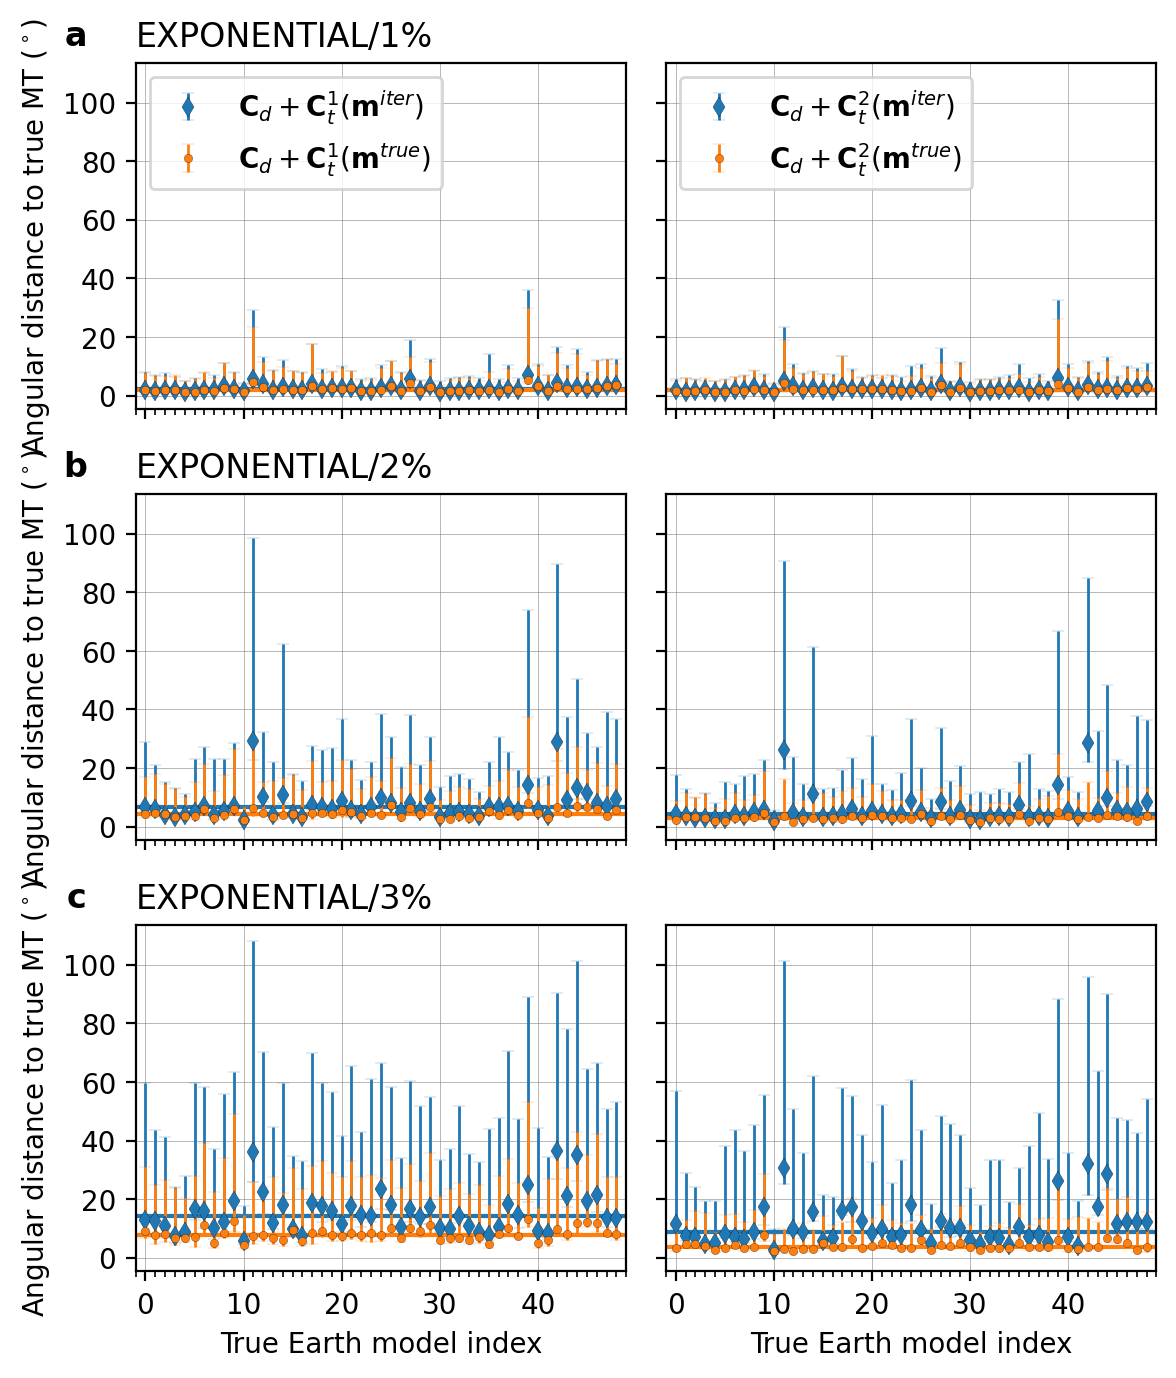

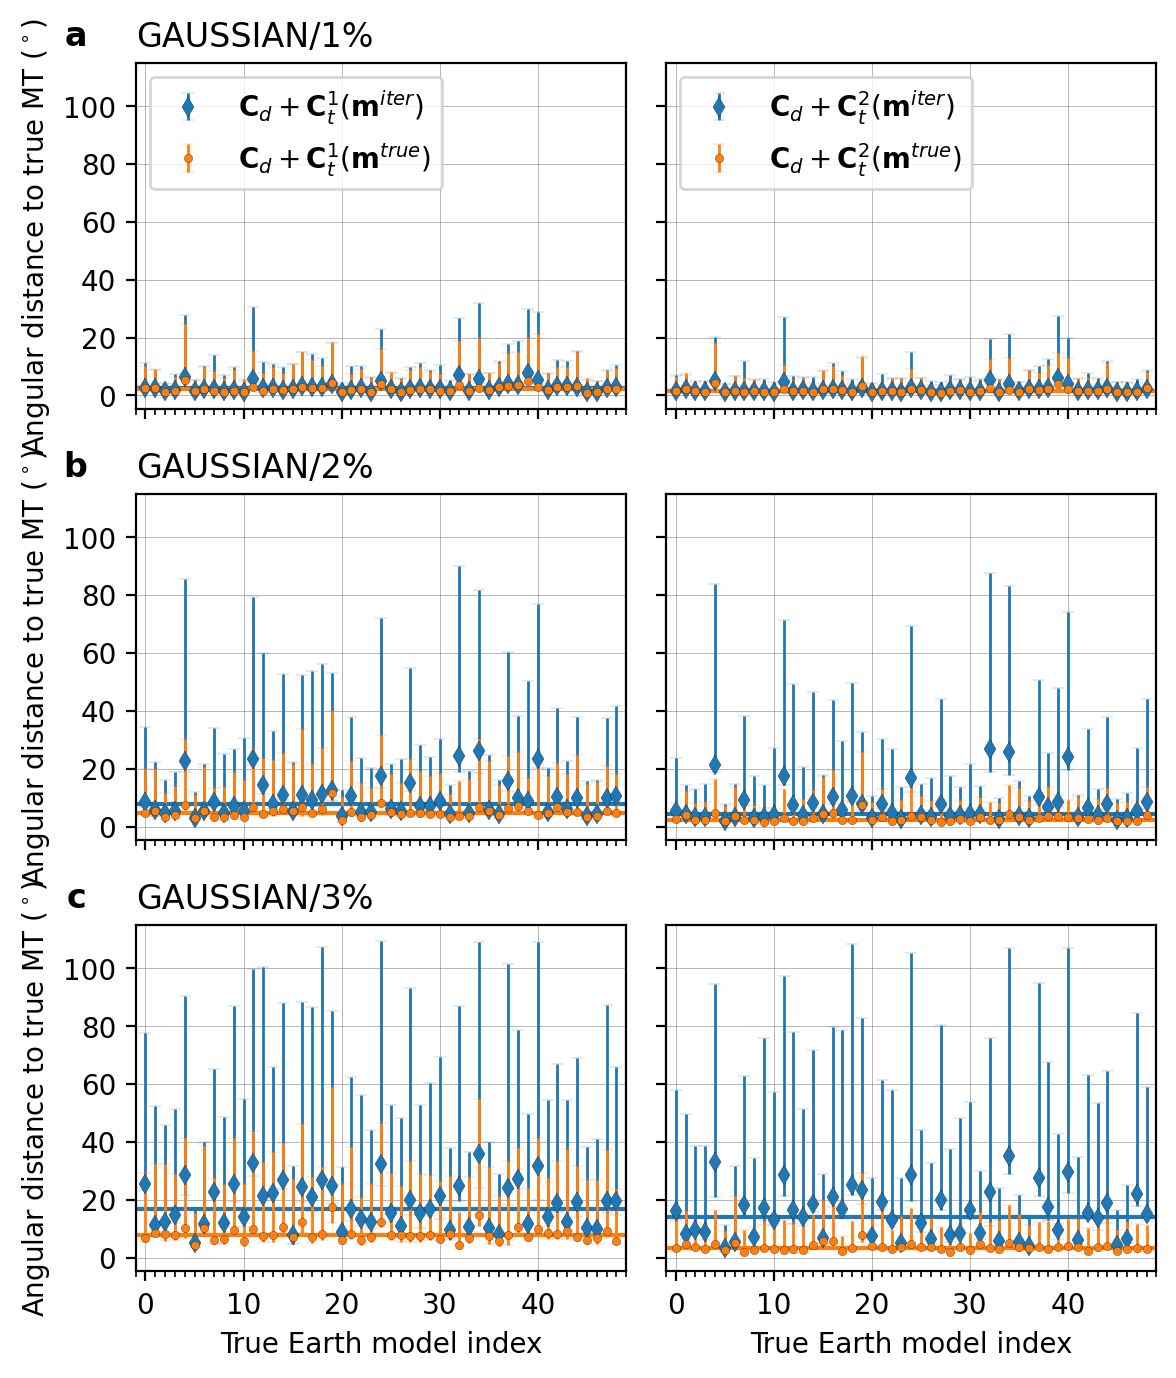

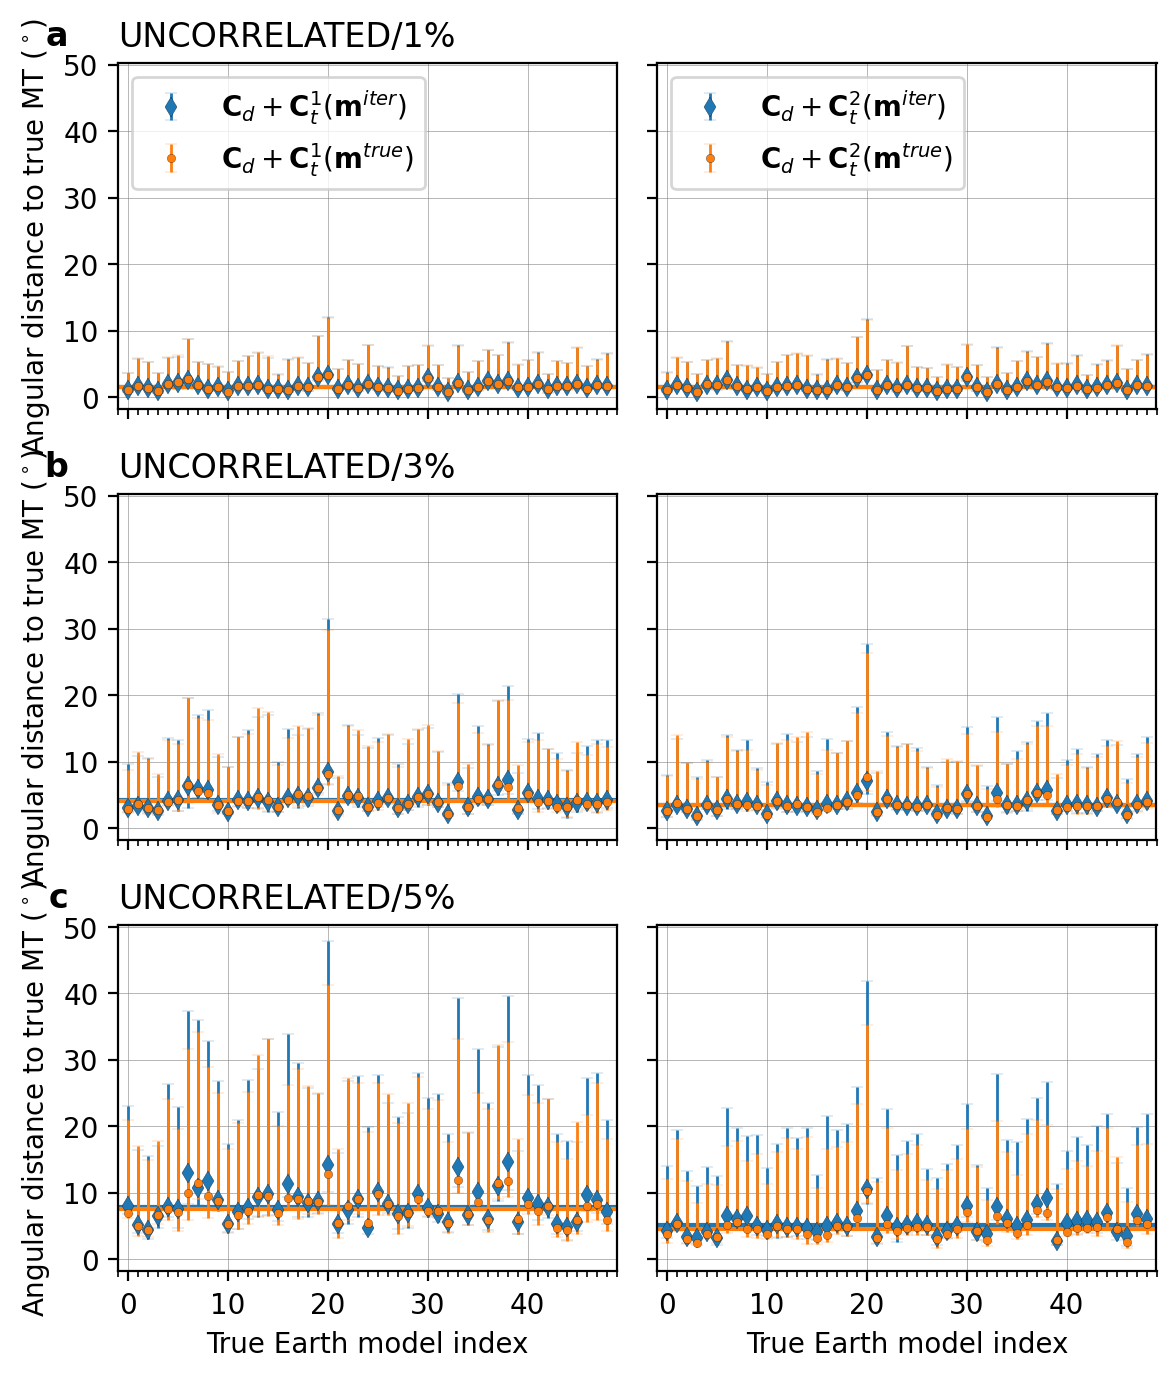

In [25]:
from obspy.geodetics import locations2degrees
from multiprocessing import Pool
import matplotlib.ticker as ticker

def _mt2lune(m6): return mt2lune(m6[...,0], m6[...,1], m6[...,2], m6[...,3], m6[...,4], m6[...,5])

## prepare directory for saving the gathered solutions
for root_dnames in [['ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/1',
               'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/2',
               'ses3d_r07_b/PERTURB_MODELS/EXPONENTIAL_3D/3'],
               ['ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/1',
               'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/2',
               'ses3d_r07_b/PERTURB_MODELS/GAUSSIAN_3D/3'], 
               ['ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/1',
               'ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/3',
               'ses3d_r07_b/PERTURB_MODELS/UNCORRELATED_3D/5']]:
    gathered_solutions_pkl = Path(f"IntegrationTests/{md5(json.dumps(root_dnames).encode('utf-8')).hexdigest()}.pkl")
    if not gathered_solutions_pkl.parent.is_dir(): gathered_solutions_pkl.parent.mkdir()

    ## repeating the solver for different true solutions
    np.random.seed(1)
    if not gathered_solutions_pkl.exists():
        gathered_dict = dict()
        repeat_counts = 50
        for _ in range(repeat_counts):
            print (f'Count: {_}/{repeat_counts}')
            m6_true = np.random.uniform(-1, 1, 6)
            lon0, lat0 = _mt2lune(m6_true)
            params = []
            for _ipath in range(len(root_dnames)):
                root_path = Path(root_dnames[_ipath])
                for use_Ct_prime in range(2):
                    tmp = (root_path, m6_true, 0.02, 1, bool(use_Ct_prime))
                    params.append(tmp)
            with Pool(6) as p: sol_dicts = p.starmap(compare_leastsquare_solutions, params)
            for param, sol_dict in zip(params, sol_dicts):
                root_path, _, _, _, use_Ct_prime = param
                use_Ct_prime = int(use_Ct_prime)
                for strucerror in ['w_strucerror', 'wu_strucerror']:
                    key = (root_path, use_Ct_prime, strucerror)
                    lon, lat = _mt2lune(sol_dict[strucerror]['mt_sol'])
                    dist = locations2degrees(lat0, lon0, lat, lon)
                    if key not in gathered_dict.keys():
                        gathered_dict[key] = []
                    gathered_dict[key].append(dist)
        with open(gathered_solutions_pkl, 'wb') as f:
            pickle.dump(gathered_dict, f)
    else:
        with open(gathered_solutions_pkl, 'rb') as f:
            gathered_dict = pickle.load(f)

    ####### Plot figure
    fig, ax = plt.subplots(len(root_dnames), 2, figsize=(6, 7), sharex=True, sharey=True)

    for use_Ct_prime in range(2):
        sol_kw = {'wu_strucerror': dict(capsize=2, elinewidth=1, fmt='d', c='C0', mec='k', mew=.1, ms=5, 
                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{iter})$'%(use_Ct_prime+1)),
                  'w_strucerror':  dict(capsize=2, elinewidth=1, fmt='o', c='C1', mec='k', mew=.1, ms=3, 
                                        label=r'$\mathbf{C}_d + \mathbf{C}^%d_t(\mathbf{m}^{true})$'%(use_Ct_prime+1))}
        for _ipath, root_path in enumerate(root_dnames):
            x = ax[_ipath, use_Ct_prime]
            for strucerror in ['wu_strucerror', 'w_strucerror']:
                tmp = gathered_dict[(Path(root_path), use_Ct_prime, strucerror)]
                mean_dist = np.median(tmp, axis=0)
                # yerr = np.std(tmp, axis=0)
                yerr = np.percentile(tmp, [5, 95], axis=0)
                # yerr = [np.min(tmp, axis=0), np.max(tmp, axis=0)]
                x.errorbar(range(len(mean_dist)), mean_dist, yerr=yerr, **sol_kw[strucerror])
                med_dist = np.median(mean_dist)
                x.axhline(med_dist, color=sol_kw[strucerror]['c'])
        ax[0, use_Ct_prime].legend(loc='upper left')
        ax[_ipath, use_Ct_prime].set(xlabel='True Earth model index')

    for _ipath in range(len(root_dnames)): 
        ax[_ipath, 0].set(ylabel='Angular distance to true MT ($^\circ$)')
        ax[_ipath, 0].annotate('%c'%(97+_ipath), xy=(-.1, 1.05), xycoords='axes fraction',
                                    ha='right', fontweight='bold', fontsize=12)
        tokens = root_dnames[_ipath].split('/')
        title = '%s/%s' % (tokens[-2][:-3], tokens[-1]) + '%'
        ax[_ipath, 0].set_title(title, loc='left')
        ax[_ipath, 0].set(xlim=(-1, len(mean_dist)))

    for x in ax.flatten(): 
        x.grid(ls='-', lw=.2, c='gray')
        x.xaxis.set_minor_locator(ticker.MultipleLocator(1))


    fig.tight_layout()
    plt.show()
    plt.close(fig)

# Visualisation of 50 random MTs used in the integration test

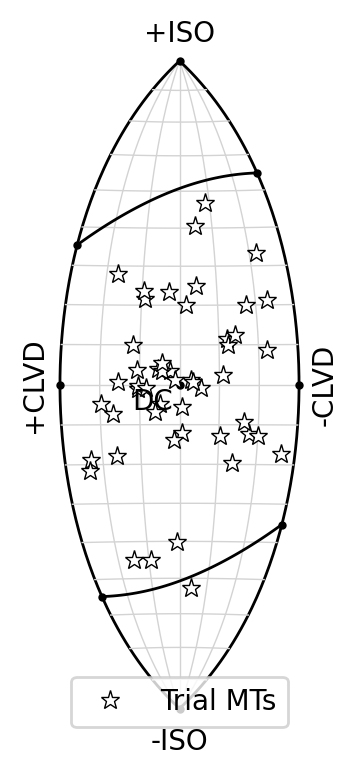

In [26]:
## plot solution on lune diagram
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
ax.set(frame_on=False, xticks=[], yticks=[])
bm = plot_lune_frame(ax)
np.random.seed(1)
m6_true = np.array([np.random.uniform(-1, 1, 6) for _ in range(50)])
x, y = bm(*mt2lune(m6_true[:, 0], m6_true[:, 1], m6_true[:, 2], m6_true[:, 3], m6_true[:, 4], m6_true[:, 5]))
ax.plot(x, y, '*', ms=7, lw=0, c='w', mec='k', mew=.5, label='Trial MTs')
ax.legend(loc='lower center')
plt.tight_layout()
plt.show()